In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
import itertools
import hurst
import math
from typing import List


In [18]:
def compute_enet( x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

In [3]:
def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 9):
    y_pred = pd.DataFrame([])
    for index in range(int(x.size))[batch_size:]:
        try:
            x_train = x[index-batch_size:index]
            y_train = y[index-batch_size:index]
            x_test = x[index+1].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
        except Exception as e:
            print(e)
    return y_pred

In [7]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy.spatial.distance import pdist
from typing import List
import sys
import math

def disten(ser: List[float], m: int = 2, tau: int = 8 , B: int = 512) -> float:
    """
    @param ser: time-series (vector in a column)
    @param m: embedding dimension (scalar)
    @param tau: time delay (scalar)
    @param B: bin number for histogram (scalar)
    """

    # rescaling
    rescaled = [y / (max(ser) - min(ser) + sys.float_info.epsilon) for y in [x - min(ser) for x in ser]]

    # distance matrix
    N = len(rescaled) - (m - 1) * tau
    if N < 0:
        raise(f"ser is too short: {len(ser)}")
    ind = hankel(np.arange(1, N+1), np.arange(N, len(rescaled)+1))
    rnt = [[rescaled[z-1] for z in y] for y in [x[::tau] for x in ind]]
    dv = pdist(rnt, 'chebychev')

    # esimating probability density by histogram
    num = pd.cut(dv, np.linspace(0, 1, B), include_lowest=True).value_counts().to_numpy()
    freq = [x / num.sum() for x in num]

    # disten calculation
    prepared = [math.log2(y) for y in [x + sys.float_info.epsilon for x in freq]]
    return -sum([x * y for (x, y) in zip(prepared, freq)]) / math.log2(B)

In [16]:
def diffusen(ser: List[float], s: int) -> float:
    '''
    Diffusion Entropy
    '''

    window_lengths = np.arange(1, int(0.25*len(ser)), 1)
    S = []
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(ser)-L, 1)
        window_ends = np.arange(L, len(ser), 1)
        displacements = ser[window_starts] - ser[window_ends]
        counts, bin_edge = np.histogram(displacements, bins='doane')
        counts = np.array(counts[counts != 0])
        binsize = bin_edge[1] - bin_edge[0]
        P = counts / sum(counts)
        S.append(-sum(P*np.log(P)) + np.log(binsize))
    return S, window_lengths

In [10]:
from tqdm import tqdm
def no_stripe_entropy(trajectory):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.
    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.
    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. FOR NO STRIPES JUST PASS THE DATA SERIES.
    Returns
    ----------
    S : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L.
    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
    S = []
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(trajectory)-L, 1)
        window_ends = np.arange(L, len(trajectory), 1)
        displacements = trajectory[window_starts] - trajectory[window_ends]
        counts, bin_edge = np.histogram(displacements, bins='doane')
        counts = np.array(counts[counts != 0])
        binsize = bin_edge[1] - bin_edge[0]
        P = counts / sum(counts)
        S.append(-sum(P*np.log(P)) + np.log(binsize))
    return S, window_lengths

In [17]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

100%|██████████| 249/249 [00:00<00:00, 3104.23it/s]


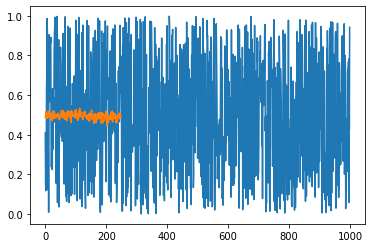

In [15]:
data = np.random.rand(1000)
result, length = no_stripe_entropy(data)
plt.plot(data)
plt.plot(result)

In [12]:
def disten_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [disten(ser[index:index+batch_size]) for index in range(len(ser[batch_size:]))]

In [17]:
def blocken(ser, trunk_size) -> List[float]:
    past = 0.
    results = []
    for y in ser:
        current_ceiled = math.ceil(y / trunk_size)
        past_ceiled = math.ceil(past / trunk_size)
        if current_ceiled == past_ceiled-1 | current_ceiled == past_ceiled+1:
            current_ceiled = past_ceiled
        current_result = current_ceiled * trunk_size
        results = results + [current_result]
        past = current_result
    return results

In [9]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [18]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [6]:
def df_to_list(df: pd.DataFrame)-> np.ndarray:
    return np.array(list(itertools.chain.from_iterable(df.to_numpy())))

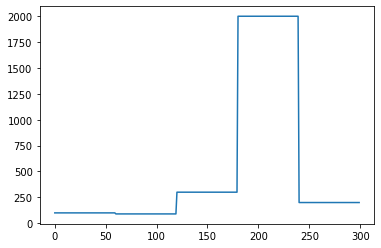

In [20]:
plt.plot([100] * 60 + [90] * 60 + [300] * 60 + [2000] * 60 + [200] * 60)

In [21]:
RangeEn_B([100] * 60 + [90] * 60 + [300] * 60 + [2000] * 60 + [200] * 60)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_92801/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


0.015328106560907374

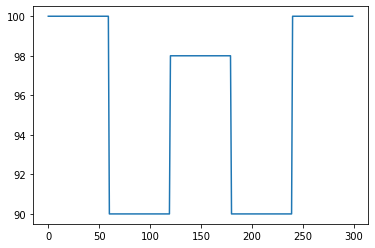

In [22]:
plt.plot([100] * 60 + [90] * 60 + [98] * 60 + [90] * 60 + [100] * 60)

In [23]:
RangeEn_B([100] * 60 + [90] * 60 + [98] * 60 + [90] * 60 + [100] * 60)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_92801/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


0.024287289339524787